In [ ]:
#import the neccessary datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Load dataset
df = pd.read_csv('train.csv',encoding="latin1")  

In [11]:
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [ ]:
#take only the necessary cols
df = df.iloc[:,2:4]

In [14]:
df.head()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


In [16]:
#check rows and cols
df.shape

(27481, 2)

In [ ]:
#fix missing values
df.dropna(inplace=True)

In [27]:
#check nan
df.isnull().sum()

selected_text    0
sentiment        0
dtype: int64

In [ ]:
# Data Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)
    return text

In [30]:
df['clean_text'] = df['selected_text'].apply(clean_text)
df.head()

,selected_text,sentiment,clean_text
0,"I`d have responded, if I were going",neutral,id have responded if i were going
1,Sooo SAD,negative,sooo sad
2,bullying me,negative,bullying me
3,leave me alone,negative,leave me alone
4,"Sons of ****,",negative,sons of


In [31]:
df["sentiment"].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [34]:
# Convert labels to numerical (Assuming binary classification: 0-Negative, 1-Positive)
df['label'] = df['sentiment'].map({'negative': 0, 'positive': 1,"neutral":2})

In [35]:
df.head()

,selected_text,sentiment,clean_text,label
0,"I`d have responded, if I were going",neutral,id have responded if i were going,2
1,Sooo SAD,negative,sooo sad,0
2,bullying me,negative,bullying me,0
3,leave me alone,negative,leave me alone,0
4,"Sons of ****,",negative,sons of,0


C:\Users\Aspire_Lays\AppData\Local\Temp\ipykernel_10704\2628071320.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df["sentiment"], order=df["sentiment"].value_counts().index, palette="viridis")


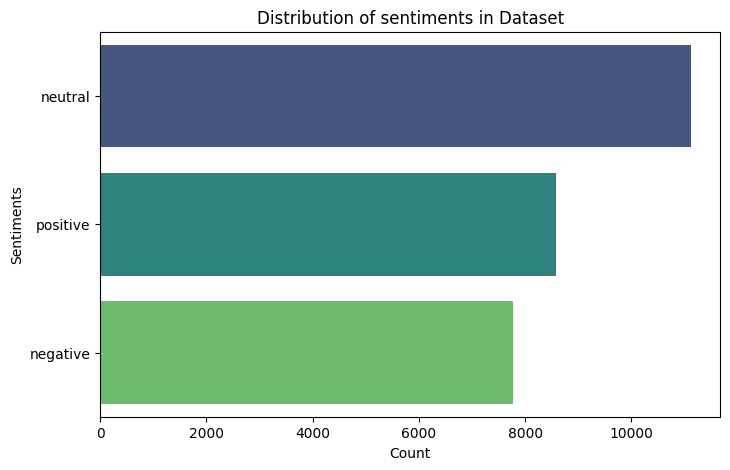

In [52]:
# Count distribution of sentiments
plt.figure(figsize=(8, 5))
sns.countplot(y=df["sentiment"], order=df["sentiment"].value_counts().index, palette="viridis")
plt.title("Distribution of sentiments in Dataset")
plt.xlabel("Count")
plt.ylabel("Sentiments")
plt.show()

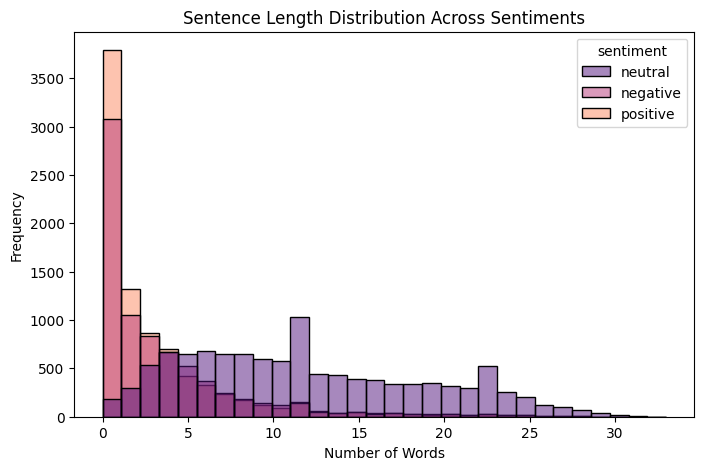

In [54]:
#sentence length distribution
# Compute sentence lengths
df["text_length"] = df["clean_text"].apply(lambda x: len(x.split()))

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(df, x="text_length", hue="sentiment", bins=30, kde=False, palette="magma")
plt.title("Sentence Length Distribution Across Sentiments")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


In [36]:
# Tokenization & Padding
MAX_WORDS = 5000  # Vocabulary size
MAX_LEN = 100  # Max sequence length
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN)

In [37]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['label'], test_size=0.2, random_state=42)

In [ ]:
# RNN Model
def build_rnn(num_classes):
    model = Sequential([
        Embedding(MAX_WORDS, 128, input_length=MAX_LEN),
        SimpleRNN(64, return_sequences=False),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax') 
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

# LSTM Model
def build_lstm(num_classes):
    model = Sequential([
        Embedding(MAX_WORDS, 128, input_length=MAX_LEN),
        LSTM(64, return_sequences=False),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

In [ ]:
# Train RNN
rnn_model = build_rnn(3)
history_rnn = rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Train LSTM
lstm_model = build_lstm(3)
history_lstm = lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.6477 - loss: 0.7949 - val_accuracy: 0.8170 - val_loss: 0.4896
Epoch 2/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.8400 - loss: 0.4524 - val_accuracy: 0.8082 - val_loss: 0.5159
Epoch 3/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.8710 - loss: 0.3591 - val_accuracy: 0.8090 - val_loss: 0.5382
Epoch 4/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.8678 - loss: 0.3673 - val_accuracy: 0.8073 - val_loss: 0.5930
Epoch 5/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9179 - loss: 0.2392 - val_accuracy: 0.8059 - val_loss: 0.6439
Epoch 6/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.9317 - loss: 0.1963 - val_accuracy: 0.7946 - val_loss: 0.7283
Epoch 7/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.9432 - loss: 0.1607 - val_accuracy: 0.7953 - val_loss: 0.8229
Epoch 8/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9449 - loss: 0.1484 - 

In [42]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = np.argmax(model.predict(X_test), axis=1)  # Get predicted class labels
    acc = accuracy_score(y_test, y_pred)

    print(f'\n{model_name} Accuracy: {acc:.4f}')
    print(classification_report(y_test, y_pred))  # Multi-class classification report

    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [43]:
def plot_learning_curves(history, model_name):
    plt.figure(figsize=(12, 5))

    # Plot loss curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss Curve')
    plt.legend()

    # Plot accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy Curve')
    plt.legend()

    plt.show()


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

RNN Accuracy: 0.7857
              precision    recall  f1-score   support

           0       0.73      0.80      0.77      1572
           1       0.82      0.81      0.81      1688
           2       0.80      0.76      0.78      2236

    accuracy                           0.79      5496
   macro avg       0.78      0.79      0.79      5496
weighted avg       0.79      0.79      0.79      5496



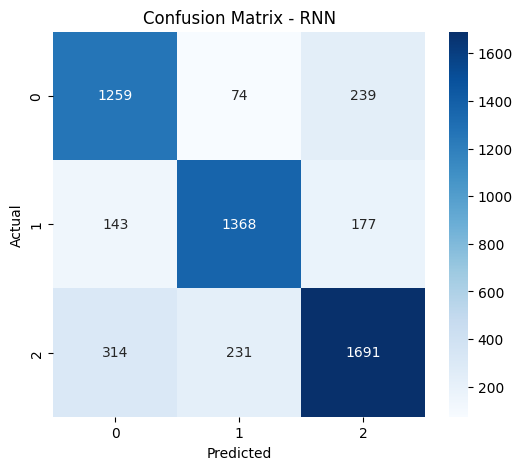

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

LSTM Accuracy: 0.8170
              precision    recall  f1-score   support

           0       0.79      0.80      0.80      1572
           1       0.87      0.81      0.84      1688
           2       0.80      0.83      0.82      2236

    accuracy                           0.82      5496
   macro avg       0.82      0.82      0.82      5496
weighted avg       0.82      0.82      0.82      5496



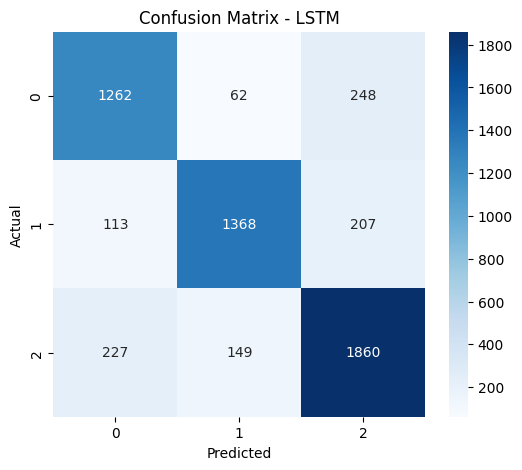

In [44]:
evaluate_model(rnn_model, X_test, y_test, 'RNN')
evaluate_model(lstm_model, X_test, y_test, 'LSTM')

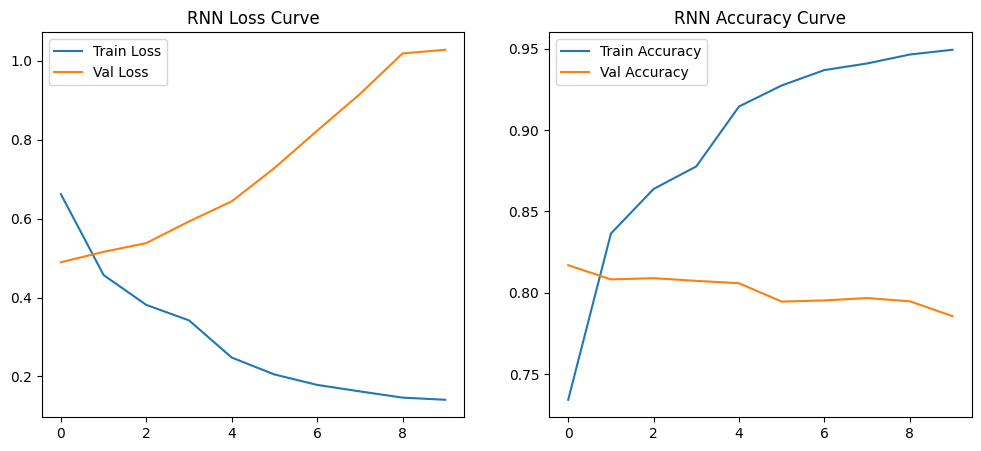

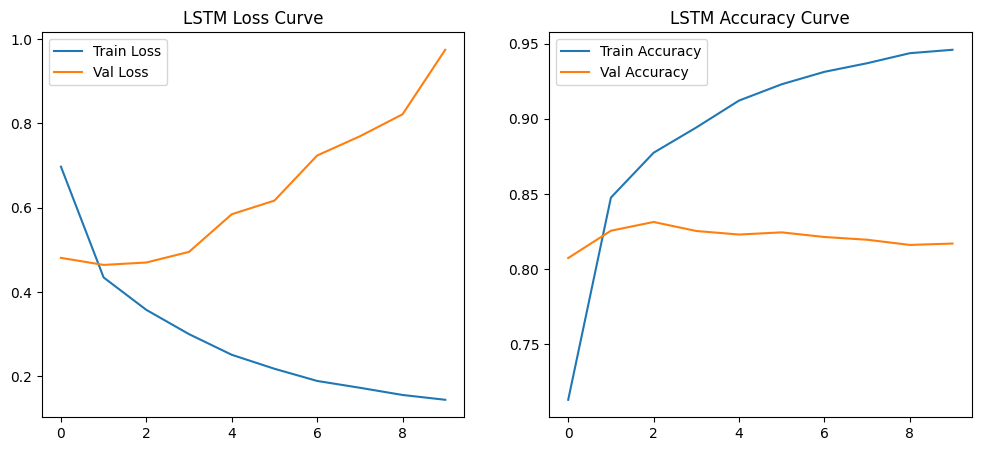

In [47]:
plot_learning_curves(history_rnn, 'RNN')
plot_learning_curves(history_lstm, 'LSTM')

<Axes: title={'center': 'Model comparision'}, xlabel='Models', ylabel='accuracy_score'>

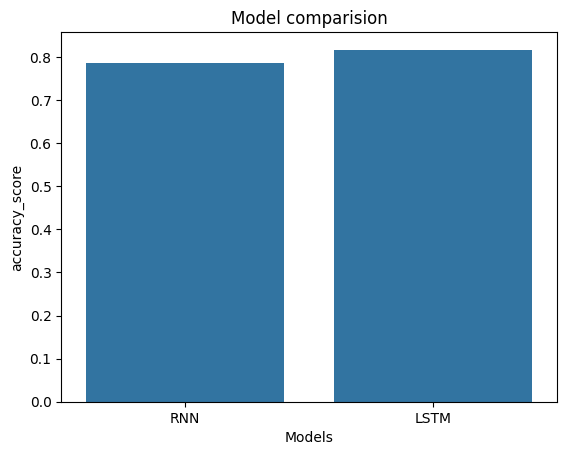

In [58]:
#model comparision
models = ["RNN","LSTM"]
accuracies = [0.7857,0.8170]
plt.title("Model comparision")
plt.xlabel("Models")
plt.ylabel("accuracy_score")
sns.barplot(x = models, y = accuracies)

In [50]:
#sentiment classes are indexed as: {0: 'Negative', 1: 'Positive', 2: 'Neutral'}
SENTIMENT_CLASSES = ['Negative','Positive','Neutral']  

def predict_sentiment(model, text):
    text = clean_text(text)  # Preprocess input text
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=MAX_LEN)
    
    pred = model.predict(padded)  # Get class probabilities
    sentiment_class = np.argmax(pred)  # Get predicted class index
    
    return SENTIMENT_CLASSES[sentiment_class]  # Return sentiment label

In [51]:
# Test Predictions
sample_texts = ["This movie was amazing!", "I did not like this product at all.", "The service was fantastic!"]
for text in sample_texts:
    print(f'Text: {text} | RNN Prediction: {predict_sentiment(rnn_model, text)} | LSTM Prediction: {predict_sentiment(lstm_model, text)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Text: This movie was amazing! | RNN Prediction: Positive | LSTM Prediction: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Text: I did not like this product at all. | RNN Prediction: Neutral | LSTM Prediction: Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Text: The service was fantastic! | RNN Prediction: Positive | LSTM Prediction: Positive


The highlight is that the LSTM model is performing better than the RNN model with LSTM giving 81% and RNN giving 78%.